### 3.3.2. TRANSFERABILITY OVER DIFFERENT SAMPLES

In [2]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path as osp
import re
import matplotlib.pyplot as plt

import sys
sys.path.append("../src")
from datasets import TabularDataset

from exp_utils import load_interactions, judge_pattern_type_single_sample, get_significant_threshold, \
    filter_raw_interaction_dict, filter_raw_interaction_dict_tictactoe

folders that stores the computed interaction

In [3]:
def get_folder(dataset, arch):
    return {
        "wifi | MLP-5":
            "../saved-interactions/dataset=wifi_balance_model=mlp5_epoch=1000_bs=128_lr=0.1_logspace=1_seed=0/dim=gt-log-odds_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=0.0001_niter=10000",
        "wifi | ResMLP-5":
            "../saved-interactions/dataset=wifi_balance_model=resmlp5_epoch=1000_bs=128_lr=0.1_logspace=1_seed=0/dim=gt-log-odds_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=0.0001_niter=10000",
        "tictactoe | MLP-5":
            "../saved-interactions/dataset=tictactoe_balance_model=mlp5_epoch=1000_bs=128_lr=0.1_logspace=1_seed=0/dim=gt-log-odds_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "tictactoe | ResMLP-5":
            "../saved-interactions/dataset=tictactoe_balance_model=resmlp5_epoch=1000_bs=128_lr=0.1_logspace=1_seed=0/dim=gt-log-odds_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | LeNet":
            "../saved-interactions/dataset=simpleisthree_model=lenet_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | ResNet-20":
            "../saved-interactions/dataset=simpleisthree_model=resnet20_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | ResNet-32":
            "../saved-interactions/dataset=simpleisthree_model=resnet32_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | ResNet-44":
            "../saved-interactions/dataset=simpleisthree_model=resnet44_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | VGG-13":
            "../saved-interactions/dataset=simpleisthree_model=vgg13_bn_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | VGG-16":
            "../saved-interactions/dataset=simpleisthree_model=vgg16_bn_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "celeba_eyeglasses | AlexNet":
            "../saved-interactions/dataset=celeba_eyeglasses_model=alexnet_epoch=20_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "celeba_eyeglasses | ResNet-18":
            "../saved-interactions/dataset=celeba_eyeglasses_model=resnet18_epoch=20_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "celeba_eyeglasses | ResNet-34":
            "../saved-interactions/dataset=celeba_eyeglasses_model=resnet34_epoch=20_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "shapenet | PointNet":
            "../saved-interactions/dataset=shapenet_model=pointnet_epoch=200_bs=32_lr=0.01_logspace=1_seed=0/dim=gt-log-odds-v0_baseline=center_loss=l1_qthres=0.04_qstd=vN-v0_lr=0.0001_niter=10000",
        "shapenet | PointNet++":
            "../saved-interactions/dataset=shapenet_model=pointnet2_epoch=200_bs=32_lr=0.01_logspace=1_seed=0/dim=gt-log-odds-v0_baseline=center_loss=l1_qthres=0.04_qstd=vN-v0_lr=0.0001_niter=10000",
    }[f"{dataset} | {arch}"]

we used the metric $\rho(k)\triangleq\mathbb{E}_{\boldsymbol{x}}[|\mathbf{D}_k\cap\Omega_{\boldsymbol{x}}|/|\Omega_{\boldsymbol{x}}|]$ to evaluate the average ratio of concepts extracted from an input sample that is covered by the concept dictionary $\mathbf{D}_k$. 

In [4]:
def evaluate_dictionary_size_explanation_ratio(all_interactions, tau, max_pattern):
    mat_pattern_type = []
    for sample_name in all_interactions.keys():
        I_and_or = torch.cat(all_interactions[sample_name])
        threshold = get_significant_threshold(I_and_or, significant_ratio=tau)
        pattern_type = judge_pattern_type_single_sample(I_and_or, threshold)
        mat_pattern_type.append(pattern_type)

    mat_pattern_type = torch.stack(mat_pattern_type)
    n_sample, n_pattern = mat_pattern_type.shape

    vec_act_rate = torch.mean(torch.abs(mat_pattern_type).float(), dim=0)  # [n_pattern,]

    mat_is_salient = mat_pattern_type != 0  # [n_sample, n_pattern]
    vec_n_concept = torch.sum(torch.abs(mat_pattern_type).float(), dim=1)  # [n_sample,]

    assert torch.all(vec_n_concept > 0)
    exp_ratio_list = []
    dict_size_list = []
    act_rate_order = torch.argsort(-torch.abs(vec_act_rate))
    for k in range(1, max_pattern + 1):
        concept_set = torch.zeros(1, n_pattern).bool()
        concept_set[:, act_rate_order[:k]] = True
        mat_explained = torch.logical_and(concept_set, mat_is_salient)  # [n_sample, n_pattern]
        vec_n_explained = mat_explained.sum(dim=1)
        vec_exp_ratio = vec_n_explained / vec_n_concept
        dict_size_list.append(k)
        exp_ratio_list.append(torch.mean(vec_exp_ratio).item())

    return dict_size_list, exp_ratio_list

plot

In [5]:
def ax_plot_curve(ax: plt.Axes, plot_dict: dict, title: str):
    for i, (key, (k_list, rho_list)) in enumerate(plot_dict.items()):
        ax.plot(k_list, rho_list, label=key)
    ax.set_title(title, style="italic")
    ax.set_xlabel("concept dictionary\n" + r"size $k=|\mathbf{D}_k|$")
    ax.set_ylabel("average explanation\n" + r"ratio $\rho(k)$")
    ax.legend()

experiment config

In [6]:
tau = 0.1

configs = [
    dict(
        dataset="tictactoe",
        arch_list=["MLP-5", "ResMLP-5"],
        max_pattern=100,
        selected_classes=[2],  # selected patterns
        title="tic-tac-toe",
    ),
    dict(
        dataset = "wifi",
        arch_list = ["MLP-5", "ResMLP-5"],
        max_pattern = 30,
        selected_classes = ["class_3"],
        title="wifi",
    ),
    dict(
        dataset = "simpleisthree",
        arch_list = ["LeNet", "ResNet-20", "ResNet-32", "ResNet-44", "VGG-13", "VGG-16"],
        max_pattern = 50,
        selected_classes = ["class_1"],
        title="MNIST-3",
    ),
    dict(
        dataset = "celeba_eyeglasses",
        arch_list = ["AlexNet", "ResNet-18", "ResNet-34"],
        selected_classes = ["class_1"],
        max_pattern = 100,
        title="CelebA-eyeglasses",
    ),
    dict(
        dataset = "shapenet",
        arch_list = ["PointNet", "PointNet++"],
        selected_classes = ["motorbike"],
        max_pattern = 100,
        title="ShapeNet",
    )
]

plot samplewise transferability

loading: 100%|██████████████| 50/50 [00:00<00:00, 796.92it/s, --> LOADING sample_00999 FROM class_1]
loading: 100%|█| 99/99 [00:00<00:00, 846.86it/s, --> LOADING sample_fad668ac64ccea1ab37378f3c85478b4
loading: 100%|█| 99/99 [00:00<00:00, 737.29it/s, --> LOADING sample_fad668ac64ccea1ab37378f3c85478b4


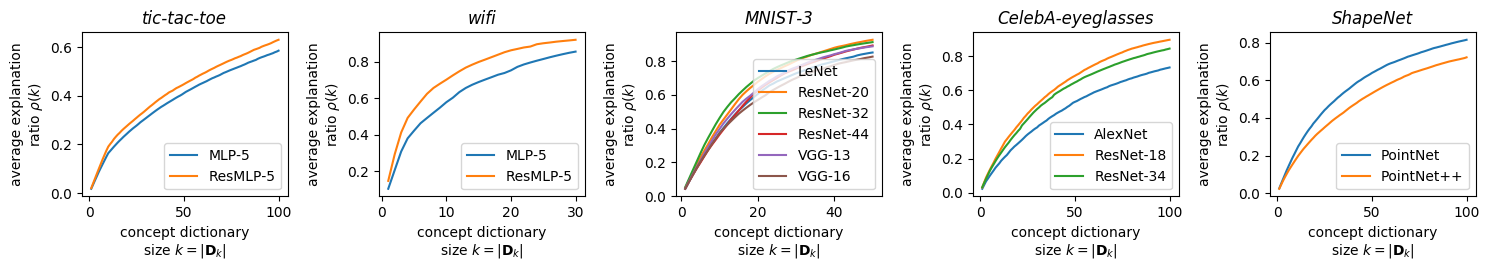

In [7]:
fig, axes = plt.subplots(1, len(configs), figsize=(3 * len(configs), 2.8))
for i, config in enumerate(configs):
    dataset = config["dataset"]
    arch_list = config["arch_list"]
    selected_classes = config["selected_classes"]
    max_pattern = config["max_pattern"]
    title = config["title"]

    if dataset == "tictactoe":
        data = TabularDataset('/data2/lmj/data/tabular', dataset)
        X_train, y_train, X_test, y_test = data.get_data()
        X_all = torch.cat([X_train, X_test])
        y_all = torch.cat([y_train, y_test])
    else:
        X_all = None

    plot_dict = {}
    for arch in arch_list:
        folder = get_folder(dataset, arch)
        interaction_dict = load_interactions(dataset, folder)
        if dataset == "tictactoe":
            interaction_dict = filter_raw_interaction_dict_tictactoe(interaction_dict, X_all, selected_classes)
        else:
            interaction_dict = filter_raw_interaction_dict(interaction_dict, selected_classes)
        k_list, rho_list = evaluate_dictionary_size_explanation_ratio(
            all_interactions=interaction_dict,
            tau=tau, max_pattern=max_pattern
        )
        plot_dict[arch] = k_list, rho_list

    ax_plot_curve(axes[i], plot_dict, title)

plt.tight_layout()
plt.show()